# Synthetic benchmark 

This notebook will show how to use NIDL (y-Aware), PCA, t-SNE and UMAP on synthetic neural datasets. 

### Install and load the packages

First, we need to install some Python packages used by NeuroCLAV:

In [ ]:
%pip install -e ../

In [ ]:
# Install UMAP package for comparison
%pip install umap-learn

In [ ]:
# Install CEBRA for comparison
%pip install cebra

In [ ]:
import sklearn
#import umap
import numpy as np
import seaborn
#import cebra
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from nidl.datasets import SyntheticDataset
from nidl.data.collate import TwoViewsCollateFunction
from nidl.volume.transforms import RandomCutout
from nidl.models import yAware, SimCLR

### Load the data and plot them

The data correspond to a 2d matrix $n \times d$ with $n=15000$ time points of $d=100$ discharge of neurons. Data follow a Poisson distribution $\mathcal{P}(\lambda(u))$ with $\lambda(u)$ modelling the firing rate of neurons and $u$ is the auxiliary variable parametrizing this rate. In practice, $\lambda(u)=f(z(u))$ for an invertible function $f$ and a latent variable $z(u)$ following a Gaussian distribution.

See pi-VAE [1] for more details.

[1] Learning identifiable and interpretable latent models of high-dimensional neural activity using pi-VAE, Zhou & Wei, NeurIPS 2020

In [2]:
dataset = SyntheticDataset(target="aux_var", path="data")

We start by plotting the latent variable $z$ to recover from the observations. It is parametrized by an auxiliary variable $u$.

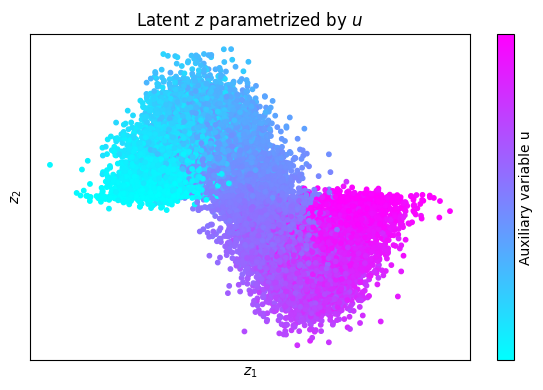

In [3]:
data = dataset.data
z, u = data['z_true'], data['u_true']
plt.figure(figsize=(6, 4))
plt.scatter(z[:, 0], z[:, 1], c=u, cmap='cool', s=10)
cbar = plt.colorbar(label='Auxiliary variable u')
plt.xticks([]); plt.yticks([]); cbar.set_ticks([])

# Add axis labels and title
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Latent $z$ parametrized by $u$')
plt.tight_layout()

plt.show()

Then, we display the actual observations X representing the neurons discarche. 

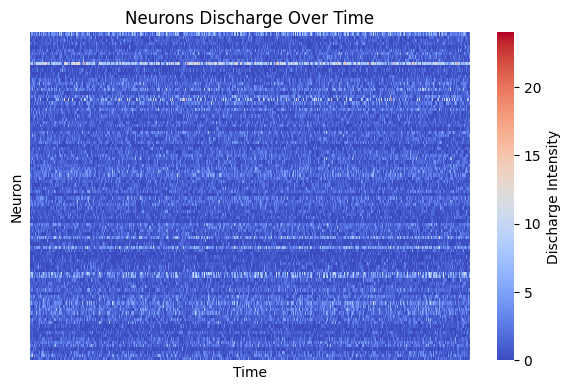

In [4]:
plt.figure(figsize=(6, 4))
seaborn.heatmap(data['x'].T, cmap='coolwarm', cbar_kws={'label': 'Discharge Intensity'}, xticklabels=False, yticklabels=False)
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.title('Neurons Discharge Over Time')
plt.tight_layout()
plt.show()

## Reconstruction score for all methods

In [5]:
def reconstruction_score(x, y):

    def _linear_fitting(x, y):
        lin_model = sklearn.linear_model.LinearRegression()
        lin_model.fit(x, y)
        return lin_model.score(x, y), lin_model.predict(x)

    return _linear_fitting(x, y)

## NIDL - yAware model

In [13]:
yaware = yAware(encoder="cebra",
                encoder_kwargs={"num_input": 100},
                kernel_kwargs=dict(kernel="gaussian", bw_method="scott"),
                projection_head=None,
                n_embedding=2,
                temperature=1.0,
                max_epochs=30)

In [14]:
train_dataloader = DataLoader(dataset, batch_size=512, num_workers=4, shuffle=True, 
                              collate_fn=TwoViewsCollateFunction(RandomCutout(num_iterations=20, p=0.5)))
test_dataloader = DataLoader(SyntheticDataset(target=None, path="data"), 
                             batch_size=512, num_workers=4, shuffle=False)

In [15]:
yaware.fit(train_dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/volatile/bd261576/miniconda3/envs/nidl/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type            | Params | Mode 
-------------------------------------------------------------
0 | encoder_         | Offset0ModelMSE | 11.0 K | train
1 | projection_head_ | Identity        | 0      | train
2 | loss_            | yAwareInfoNCE   | 0      | train
-------------------------------------------------------------
11.0 K    Trainable params
0         Non-trainable params
11.0 K    Total params
0.044     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
/volatile/bd261576/miniconda3/envs/nidl/lib/python3.10/site-packages/pytorch_lightning/loops/

Epoch 0:   0%|          | 0/30 [00:00<?, ?it/s] Bandwidth automatically set to:
 [[0.20601834]]
Epoch 29: 100%|██████████| 30/30 [00:02<00:00, 13.45it/s, v_num=19, loss/train=10.90]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 30/30 [00:02<00:00, 13.16it/s, v_num=19, loss/train=10.90]


yAware(
  (encoder_): Offset0ModelMSE(
    (net): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=100, out_features=60, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=60, out_features=60, bias=True)
      (4): GELU(approximate='none')
      (5): Linear(in_features=60, out_features=20, bias=True)
      (6): GELU(approximate='none')
      (7): Linear(in_features=20, out_features=2, bias=True)
    )
  )
  (projection_head_): Identity()
  (loss_): yAwareInfoNCE(
    (sim_metric): PairwiseCosineSimilarity()
  )
)

(np.float64(-0.9875877261161805),
 np.float64(6.49254230260849),
 np.float64(-3.0659494519233705),
 np.float64(2.971501123905182))

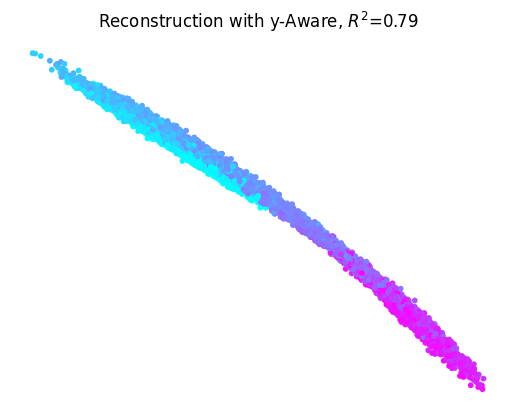

In [16]:
embedding = yaware.transform(test_dataloader)
yaware_score, embedding_z = reconstruction_score(embedding, dataset.data["z_true"])
plt.scatter(embedding_z[:, 0], embedding_z[:, 1], c=dataset.data["u_true"], s=10, cmap="cool")
plt.title(f"Reconstruction with y-Aware, $R^2$={yaware_score:.2f}")
plt.axis("off")

## NIDL - SimCLR



In [ ]:
simclr = SimCLR(encoder="cebra",
                encoder_kwargs={"num_input": 100},
                kernel_kwargs=dict(kernel="gaussian", bw_method="scott"),
                projection_head=None,
                n_embedding=2,
                temperature=1.0,
                max_epochs=30)

## t-SNE 

In [12]:
t_sne = sklearn.manifold.TSNE(
    perplexity=84,
    n_components=2,
    init='pca',
    random_state=None,
    metric='euclidean')

In [13]:
tsne_output = t_sne.fit_transform(dataset.data['x'])

(np.float64(-0.210592794418335),
 np.float64(6.570907163619995),
 np.float64(-2.4666185855865477),
 np.float64(2.3385916233062742))

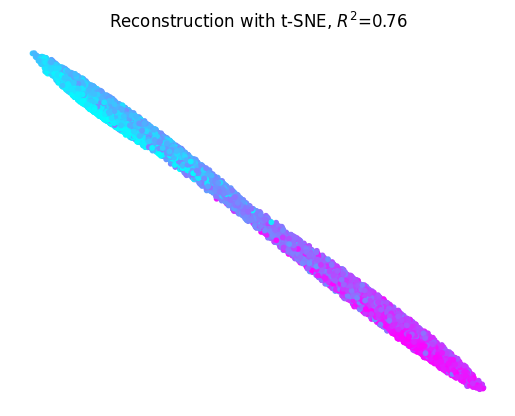

In [14]:
tsne_score, tsne_embedding = reconstruction_score(tsne_output, dataset.data['z_true'])
plt.scatter(tsne_embedding[:, 0],
            tsne_embedding[:, 1],
            c=dataset.data['u_true'],
            s=10,
            cmap='cool')
plt.title(f"Reconstruction with t-SNE, $R^2$={tsne_score:.2f}")
plt.axis('off')

## UMAP

In [15]:
umap_model = umap.UMAP(n_neighbors=68,
                       min_dist=0.2475,
                       n_components=2,
                       random_state=None,
                       metric='euclidean')
umap_output = umap_model.fit_transform(dataset.data['x'])

/volatile/bd261576/miniconda3/envs/neuroclav/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/volatile/bd261576/miniconda3/envs/neuroclav/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


(np.float64(-0.38708113431930546),
 np.float64(6.9663288474082945),
 np.float64(-2.5795987248420715),
 np.float64(2.79119211435318))

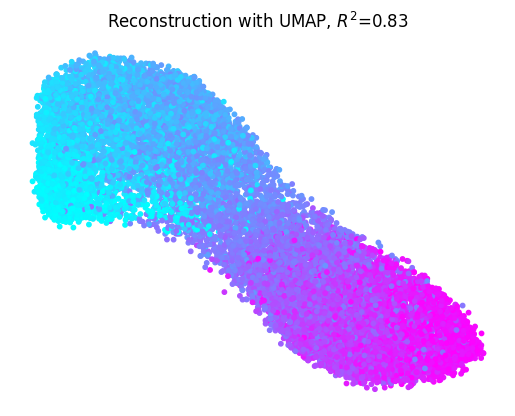

In [16]:
umap_score, transformed_umap_z = reconstruction_score(umap_output, dataset.data['z_true'])
plt.scatter(transformed_umap_z[:, 0],
            transformed_umap_z[:, 1],
            c=dataset.data['u_true'],
            s=10,
            cmap='cool')
plt.title(f"Reconstruction with UMAP, $R^2$={umap_score:.2f}")
plt.axis('off')

## CEBRA

In [22]:
cebra_model = cebra.CEBRA(
    model_architecture="offset1-model-mse",
    batch_size=512,
    learning_rate=1e-4,
    max_iterations=5000,
    delta=0.1,
    conditional='delta',
    output_dimension=2,
    distance='euclidean',
    device="cuda_if_available",
    verbose=True,
)
cebra_output = cebra_model.fit_transform(dataset.data['x'], dataset.data['u_true'])

pos:  0.6260 neg:  4.6052 total:  5.2312 temperature:  1.0000: 100%|██████████| 5000/5000 [01:17<00:00, 64.39it/s]


(np.float64(-0.9529336899518968),
 np.float64(8.064434251189232),
 np.float64(-2.871117961406708),
 np.float64(2.7041431784629824))

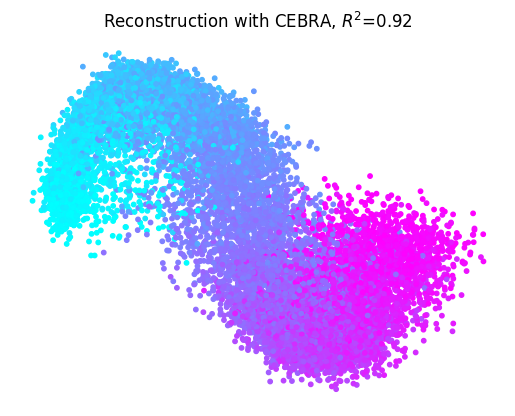

In [23]:
cebra_score, transformed_cebra_z = reconstruction_score(cebra_output, dataset.data['z_true'])
plt.scatter(transformed_cebra_z[:, 0],
            transformed_cebra_z[:, 1],
            c=dataset.data['u_true'],
            s=10,
            cmap='cool')
plt.title(f"Reconstruction with CEBRA, $R^2$={cebra_score:.2f}")
plt.axis('off')